# Clase 22: Regresión Espacial


In [4]:
#!pip install spreg

In [41]:
import pysal
import numpy as np
#from pysal import spreg
from pysal.model import spreg
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns

In [3]:
dat=gpd.read_file('regression_db.geojson')
dat

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,14668,0,0,1,0,0,0,1,0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,38245,0,0,1,0,0,0,1,0,POINT (-117.21870 32.74202)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6105,2,1.0,1.0,1.0,University City,1,16.924951,0,79.0,4.369448,13882013,1,0,0,0,0,0,1,0,POINT (-117.21635 32.87142)
6106,6,2.0,2.0,2.0,Marina,0,2.821975,0,295.0,5.686975,13882245,0,1,0,0,0,1,0,0,POINT (-117.16342 32.71036)
6107,1,1.0,1.0,1.0,North Hills,0,1.990988,0,65.0,4.174387,13882335,0,0,1,0,0,0,1,0,POINT (-117.12986 32.74252)
6108,3,1.0,1.0,1.0,East Village,1,2.060319,0,170.0,5.135798,13882606,1,0,0,0,0,1,0,0,POINT (-117.15070 32.71322)


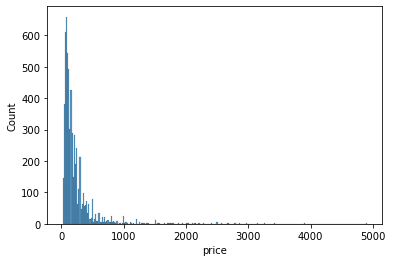

In [4]:
sns.histplot(data=dat,x='price');

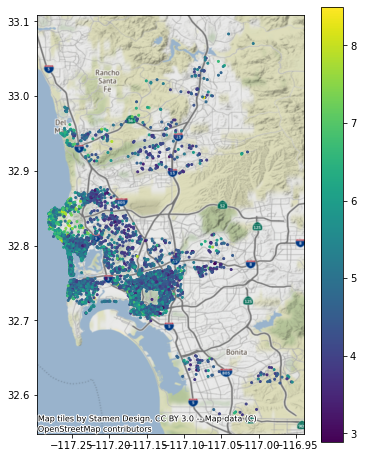

In [5]:
fig=plt.figure(figsize=(6,8))
ax=fig.add_subplot(111)
dat.plot(ax=ax,column='log_price',legend=True,markersize=4);
ctx.add_basemap(ax, crs=dat.crs);


## Regresión no-espacial.

#### Objetivo: 
Explicar la variación en una variables *dependiente*, como una función lineal de una colección de variables *independientes* o *explicativas*.

#### Ejemplo:
Explicar el precio de una casa como una función del nº de habitaciones, y otras características.

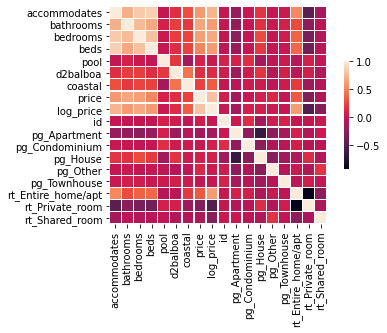

In [6]:
corr = dat.corr()
sns.heatmap(corr, square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [118]:
x_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

In [119]:
y = dat['log_price'].values
y.shape = (len(y),1)
X= dat[x_names].values

In [120]:
ls = spreg.ols.OLS(y, X, name_y = 'log_price', name_x = x_names)
print(ls.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
R-squared           :      0.6683
Adjusted R-squared  :      0.6678
Sum squared residual:    1320.148                F-statistic           :   1229.0564
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3988.895
Sigma-square ML     :       0.216                Akaike info criterion :    7999.790
S.E of regression ML:      0.4648                Schwarz criterion     :    8073.685

-----------------------------------------------------------------------------

In [10]:
b=ls.betas
b.T

array([[ 4.38838296,  0.08345234,  0.19237898,  0.15252209, -0.04172306,
        -0.55068681, -1.23830552,  0.14363474, -0.0104894 ,  0.14115461,
        -0.04167017]])

Este modelo en general funciona bien, logrando predecir ~67% (2/3) de la variación en el precio usando las variables explicativas definidas arriba.
Pero, puede haber cierta aglomeración espacial en los errores, lo cual contradice las suposiciones del modelo lineal original.

#### ¿Hay estructura espacial en los residuos?

Por ejemplo, ¿el modelo falla más al predecir los precios de propiedades cerca de la costa?

In [11]:
dat['res']=ls.u
dat['y_pred']=ls.predy

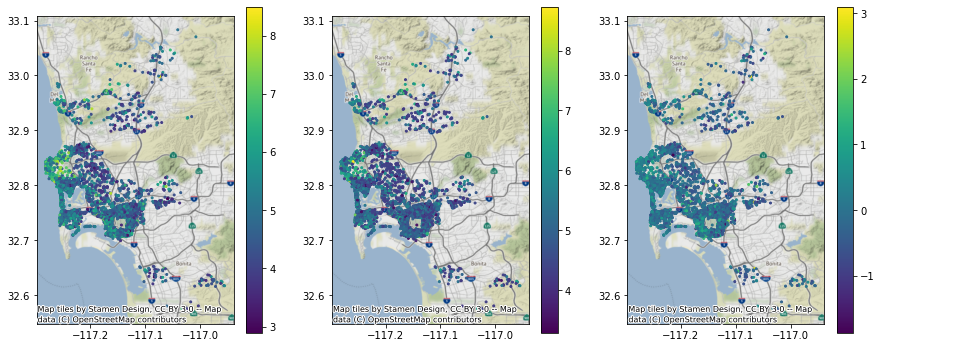

In [12]:
import matplotlib.pyplot as plt
fig,axes=plt.subplots(figsize=(15,6),nrows=1,ncols=3)

dat.plot(ax=axes[0],column='log_price',legend=True,markersize=4)
dat.plot(ax=axes[1],column='y_pred',legend=True,markersize=4)
dat.plot(ax=axes[2],column='res',legend=True,markersize=4);

for ax in axes:
    ctx.add_basemap(ax, crs=dat.crs);


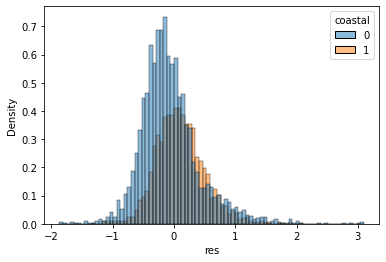

In [13]:
sns.histplot(data=dat,x='res',hue='coastal',stat='density');

**Test T-student:** asume que dos distribuciones independientes son idénticas.

Si el valor-p es cercano a cero, se rechaza la hipótesis con altísima probabilidad.

In [14]:
from scipy.stats import ttest_ind

coastal=dat[dat['coastal']==1]['res']
not_coastal=dat[dat['coastal']==0]['res']

ttest_ind(coastal, not_coastal)

Ttest_indResult(statistic=13.98193857851395, pvalue=9.442438000945613e-44)

#### Más aún,  ¿hay diferencias en los residuos dependediendo del vecindario?

Por ejemplo, debido a preferencias no modeladas, marketing, penalidades asociadas a variables no consideradas (contaminación, ruido, etc).

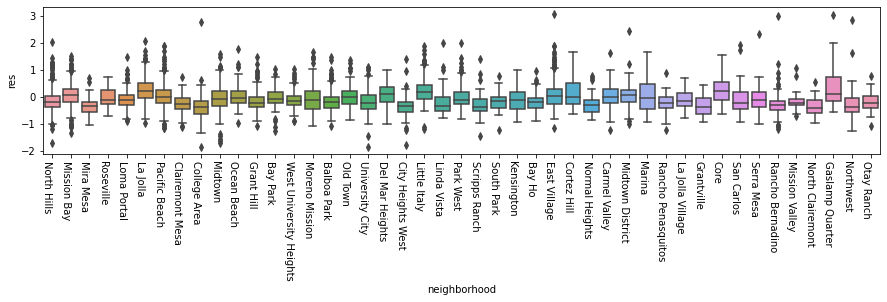

In [15]:
# Set up figure
f = plt.figure(figsize=(15, 3))
# Grab figure's axis
ax = plt.gca()

sns.boxplot(y="res",x="neighborhood",ax=ax,data=dat)
f.autofmt_xdate(rotation=-90);

In [16]:
from libpysal import weights

w=weights.KNN.from_dataframe(dat,k=20)
w.transform='R'

/Users/paguirre/opt/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


In [17]:
import esda 

moran = esda.moran.Moran(dat["res"], w)
moran.I

0.14159081170594773

(-1.869282843800689,
 3.096608617051717,
 -0.6668836666560446,
 0.7023764685418874)

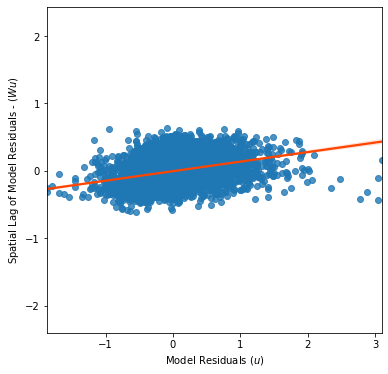

In [18]:
dat['lag_res'] = weights.spatial_lag.lag_spatial(w, dat['res'])

fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111)
sns.regplot(x=dat['res'],y=dat['lag_res'],line_kws=dict(color="orangered"))

ax.set_xlabel("Model Residuals ($u$)")
ax.set_ylabel("Spatial Lag of Model Residuals - ($W u$)");
ax.axis('equal')

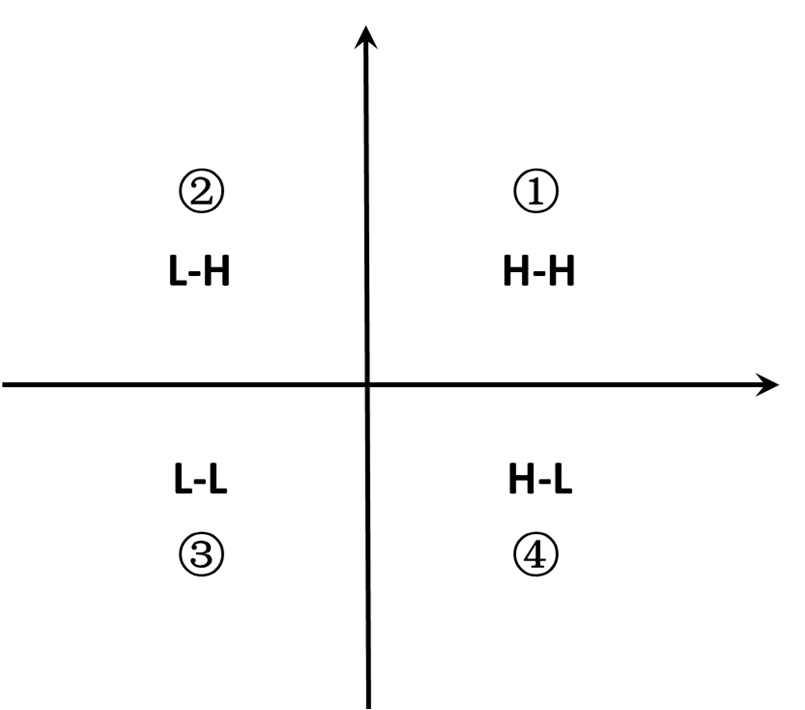

In [20]:
outliers = esda.moran.Moran_Local(dat['res'], w, permutations=999)

In [21]:
dat['q']=outliers.q
dat['p_sim']=outliers.p_sim
dat['local_I']=outliers.Is

In [22]:
error_clusters=dat[(dat.q==1) & (dat.p_sim<=0.001)].sort_values(by="local_I",ascending=False)
error_clusters

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,...,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry,res,y_pred,q,p_sim,local_I
1112,3,1.0,0.0,1.0,Gaslamp Quarter,0,2.234856,0,900.0,6.802395,...,0,1,0,0,POINT (-117.16047 32.71506),1.871844,4.930551,1,0.001,3.861911
3360,4,1.0,1.0,2.0,Gaslamp Quarter,0,2.270279,0,599.0,6.395262,...,0,0,1,0,POINT (-117.16076 32.71484),1.821147,4.574115,1,0.001,3.851726
2343,4,1.5,0.0,3.0,Gaslamp Quarter,0,2.187274,0,995.0,6.902743,...,0,1,0,0,POINT (-117.16059 32.71566),1.873516,5.029226,1,0.001,3.463658
1069,2,1.0,1.0,1.0,East Village,0,3.303973,0,165.0,5.105945,...,0,0,0,1,POINT (-117.15838 32.70344),1.485785,3.620160,1,0.001,3.445374
2159,2,1.0,1.0,1.0,Marina,0,2.774850,0,450.0,6.109248,...,0,0,1,0,POINT (-117.16815 32.71426),1.657834,4.451414,1,0.001,3.334497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,4,1.0,2.0,2.0,La Jolla,0,16.277209,1,200.0,5.298317,...,0,1,0,0,POINT (-117.27858 32.82694),0.020993,5.277324,1,0.001,0.045357
5599,4,1.0,0.0,1.0,Gaslamp Quarter,0,2.312563,0,153.0,5.030438,...,0,1,0,0,POINT (-117.16008 32.71399),0.013955,5.016483,1,0.001,0.026611
622,2,1.0,1.0,1.0,Little Italy,1,2.450124,0,75.0,4.317488,...,0,0,1,0,POINT (-117.16996 32.72139),0.009709,4.307779,1,0.001,0.019303
3120,1,1.0,1.0,1.0,La Jolla,0,16.374125,1,68.0,4.219508,...,0,0,1,0,POINT (-117.27955 32.82733),0.005671,4.213837,1,0.001,0.009430


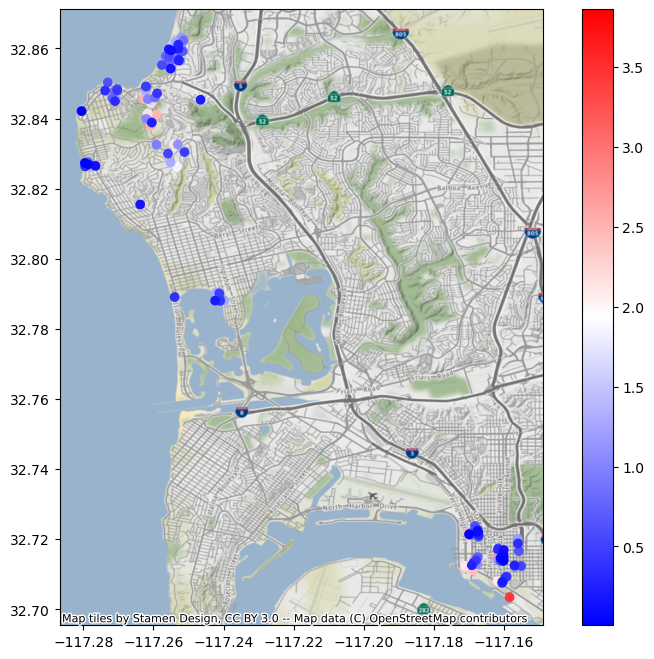

In [23]:
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(111)
error_clusters.plot(ax=ax,column='local_I',cmap="bwr",legend=True);
ctx.add_basemap(ax, crs=dat.crs);


## Heterogeneidad espacial.

El modelo puede cambiar significativamente de acuerdo a la geografía. Por ejemplo, algunos barrios pueden ser sistemáticamente más caros que otros, independiente de las características de las propiedades.

La heterogeneidad espacial puede reflejarse en cambios en el valor de el intercepto $\alpha$ (distintos valor base entre áreas geográficas) o en los valores de los coeficientes $\beta$ (distinta relación entre las variables dependientes e independientes a traés del espacio).

### Efectos espaciales fijos

In [24]:
# spreg spatial fixed effect implementation
m_fe = spreg.OLS_Regimes(
    
    # Variable dependiente
    dat[["log_price"]].values,
    
    # Variables independientes
    dat[x_names].values,
    
    # Variable que identifica el barrio
    dat["neighborhood"].tolist(),
    
    # Allow the constant term to vary by group/regime
    constant_regi="many",
    
    # Variables dependientes cuyos coeficientes beta pueden variar (True) o que son iguales para todos los barrios
    # (False). Here we set all to False
    cols2regi=[False] * len(x_names),
    
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=x_names,
)


In [26]:
print(m_fe.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          55
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6055
R-squared           :      0.7118
Adjusted R-squared  :      0.7092
Sum squared residual:    1147.169                F-statistic           :    276.9408
Sigma-square        :       0.189                Prob(F-statistic)     :           0
S.E. of regression  :       0.435                Log likelihood        :   -3559.832
Sigma-square ML     :       0.188                Akaike info criterion :    7229.664
S.E of regression ML:      0.4333                Schwarz criterion     :    7599.137

---------------------------------------------------------

In [67]:
#¿cuantos vecindarios?
n_areas=len(dat['neighborhood'].unique())
print(n_areas)
#¿cuantas variables dependientes?
n_global=len(x_names)
print(n_global)

45
10


In [77]:
#obtenemos los valores de alpha para cada barrio

alpha_fe=[]
neigh_fe=[]
for neigh,alpha in zip(m_fe.name_x[0:n_areas],m_fe.betas[0:n_areas]):
    alpha_fe.append(alpha[0])
    neigh_fe.append(neigh.split('_')[0])

df_fe=pd.DataFrame()
df_fe['neighbourhood']=neigh_fe
df_fe['alpha_fe']=alpha_fe
df_fe

,neighbourhood,alpha_fe
0,Balboa Park,4.280766
1,Bay Ho,4.198251
2,Bay Park,4.329223
3,Carmel Valley,4.389261
4,City Heights West,4.053518
5,Clairemont Mesa,4.095259
6,College Area,4.033697
7,Core,4.726186
8,Cortez Hill,4.608090
9,Del Mar Heights,4.496910


In [89]:
#unión con la cartografía de los barrios
sd_path = "neighbourhoods.geojson"
neighborhoods = gpd.read_file(sd_path)
neighborhoods.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   neighbourhood        108 non-null    object  
 1   neighbourhood_group  0 non-null      object  
 2   geometry             108 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 2.7+ KB


In [92]:
neighborhoods=neighborhoods.merge(df_fe,how="left",on="neighbourhood").dropna(subset=["alpha_fe"])

/Users/paguirre/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


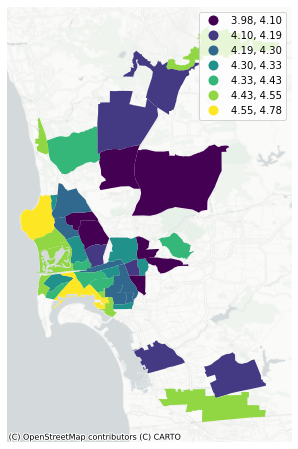

In [93]:
#gráfico de efectos espaciales fijos 

fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(111)

neighborhoods.plot("alpha_fe",  # Variable to display
    scheme="quantiles",  # Choropleth scheme
    k=7,  # No. of classes in the choropleth
    linewidth=0.1,  # Polygon border width
    cmap="viridis",  # Color scheme
    ax=ax,legend=True)
# Add basemap
ctx.add_basemap(ax,crs=neighborhoods.crs,source=ctx.providers.CartoDB.PositronNoLabels,)
ax.set_axis_off()
plt.show()


### Regímenes espaciales

Ahora variamos no sólo la constante, sino que también los coeficientes beta para cada región.
En este caso consideraremos un modelo para los barrios costeros (`coastal=1`), y otro para los barrios lejanos a la costa (`coastal=0`)


In [94]:
# spreg spatial fixed effect implementation
m_sreg = spreg.OLS_Regimes(
    
    # Variable dependiente
    dat[["log_price"]].values,
    
    # Variables independientes
    dat[x_names].values,
    
    # Variable que identifica el barrio
    dat["coastal"].tolist(),
    
    # Allow the constant term to vary by group/regime
    constant_regi="many",
    
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=x_names,
)

In [97]:
print(m_sreg.summary)

REGRESSION
----------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION - REGIME 0
---------------------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  : 0_log_price                Number of Observations:        3808
Mean dependent var  :      4.7871                Number of Variables   :          11
S.D. dependent var  :      0.7376                Degrees of Freedom    :        3797
R-squared           :      0.5665
Adjusted R-squared  :      0.5654
Sum squared residual:     897.884                F-statistic           :    496.2706
Sigma-square        :       0.236                Prob(F-statistic)     :           0
S.E. of regression  :       0.486                Log likelihood        :   -2652.383
Sigma-square ML     :       0.236                Akaike info criterion :    5326.766
S.E of regression ML:      0.4856                Schwarz criterion     :    5395.459

--------------------------------

## Dependencia Espacial.

### Efectos exógenos.

Incluimos el lag espacial de alguna(s) de las variable(s) dependientes.

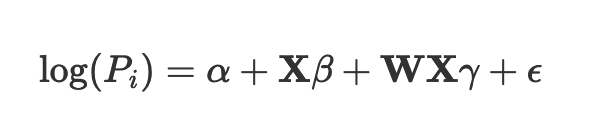

In [99]:
dat.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'neighborhood', 'pool',
       'd2balboa', 'coastal', 'price', 'log_price', 'id', 'pg_Apartment',
       'pg_Condominium', 'pg_House', 'pg_Other', 'pg_Townhouse',
       'rt_Entire_home/apt', 'rt_Private_room', 'rt_Shared_room', 'geometry',
       'res', 'y_pred', 'lag_res'],
      dtype='object')

Por ejemplo, ¿cuál es el efecto de que una propiedad esté en una zona de condominios?

In [125]:
from libpysal import weights

w=weights.KNN.from_dataframe(dat,k=20)
w.transform='R'

for var in ['pg_Condominium', 'pg_House', 'pg_Other', 'pg_Townhouse']:
    wx=weights.spatial_lag.lag_spatial(w,dat[var])
    dat['slag_%s'%var]=wx

/Users/paguirre/opt/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


In [126]:
dat.head()

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,...,rt_Private_room,rt_Shared_room,geometry,res,y_pred,lag_res,slag_pg_Condominium,slag_pg_House,slag_pg_Other,slag_pg_Townhouse
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,...,0,0,POINT (-117.12971 32.75399),0.650578,5.401511,-0.336402,0.00,0.45,0.2,0.00
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,...,0,0,POINT (-117.25253 32.78421),-0.040253,5.363263,0.062948,0.30,0.35,0.0,0.05
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,...,1,0,POINT (-117.14121 32.75327),0.287341,4.307779,-0.036456,0.05,0.30,0.0,0.05
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,...,1,0,POINT (-117.15269 32.93110),-0.020623,4.297289,-0.305422,0.00,0.95,0.0,0.05
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,...,1,0,POINT (-117.21870 32.74202),-0.289956,4.297289,0.030832,0.05,0.85,0.0,0.00


In [127]:
# Nombres de variables
x_names_exog=['accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'rt_Private_room',
 'rt_Shared_room',
 'pg_Condominium',
 'pg_House',
 'pg_Other',
 'pg_Townhouse','pg_Condominium',
 'slag_pg_Condominium', 'slag_pg_House', 'slag_pg_Other', 'slag_pg_Townhouse']

dat[x_names_exog]

,accommodates,bathrooms,bedrooms,beds,rt_Private_room,rt_Shared_room,pg_Condominium,pg_House,pg_Other,pg_Townhouse,pg_Condominium,slag_pg_Condominium,slag_pg_House,slag_pg_Other,slag_pg_Townhouse
0,5,2.0,2.0,2.0,0,0,0,1,0,0,0,0.00,0.45,0.20,0.00
1,6,1.0,2.0,4.0,0,0,1,0,0,0,1,0.30,0.35,0.00,0.05
2,2,1.0,1.0,1.0,1,0,0,0,0,0,0,0.05,0.30,0.00,0.05
3,2,1.0,1.0,1.0,1,0,0,1,0,0,0,0.00,0.95,0.00,0.05
4,2,1.0,1.0,1.0,1,0,0,1,0,0,0,0.05,0.85,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6105,2,1.0,1.0,1.0,1,0,0,0,0,0,0,0.30,0.05,0.00,0.00
6106,6,2.0,2.0,2.0,0,0,1,0,0,0,1,0.05,0.00,0.60,0.00
6107,1,1.0,1.0,1.0,1,0,0,1,0,0,0,0.00,0.55,0.25,0.00
6108,3,1.0,1.0,1.0,0,0,0,0,0,0,0,0.00,0.05,0.05,0.00


In [128]:
# Fit linear model with `spreg`
m_exog= spreg.OLS(
    y,
    dat[x_names_exog].values,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=x_names_exog,
)


/Users/paguirre/opt/anaconda3/lib/python3.8/site-packages/spreg/diagnostics.py:352: RuntimeWarning: invalid value encountered in sqrt
  se_result = np.sqrt(variance)
/Users/paguirre/opt/anaconda3/lib/python3.8/site-packages/spreg/diagnostics.py:167: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(variance)


In [129]:
print(m_exog.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          16
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6094
R-squared           :-8603445716277092052352986863632384.0000
Adjusted R-squared  :-8624622560015877744867294593417216.0000
Sum squared residual:34245835134561272872899472466322128896.000                F-statistic           :    406.2667
Sigma-square        :5619598807771787383473164462850048.000                Prob(F-statistic)     :           0
S.E. of regression  :74963983403843920.000                Log likelihood        : -246070.545
Sigma-square ML     :5604883000746525622201543074775040.000                Akaike info criterion :  492173.090
S.E of regressio